In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import time
from tqdm import tqdm
from scipy.stats import pearsonr

print('done')

%load_ext autoreload
%autoreload 2

done


In [2]:
import torch
# Check GPU availability
use_gpu = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_gpu \
        else torch.FloatTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# small function to plot images
def showTensor(aTensor, pos=111):
    plt.subplot(int(pos))
    plt.imshow(aTensor)    #,cmap='viridis')
    plt.colorbar()
    #plt.show()
    plt.rcParams["axes.grid"] = False

In [4]:
# Functions to create complex tensors (ie, split real & img parts) + transfer between numpy and pytorch

def to_complex_tensor(stuff):
    # TO_COMPLEX_TENSOR transforms a complex nparray into a complex tensor
    # The real and imaginary part are concatenated along the last dimension
    
    # Retrieve real and imaginary parts in separate tensors
    stuff_r = torch.from_numpy(np.real(stuff)).to(device).float()
    stuff_i = torch.from_numpy(np.imag(stuff)).to(device).float()
    
    # Add a last dimension
    stuff_r = torch.unsqueeze(stuff_r, dim=stuff_r.ndimension())
    stuff_i = torch.unsqueeze(stuff_i, dim=stuff_i.ndimension())
    
    # Return the concatenation
    return torch.cat((stuff_r, stuff_i), dim=-1)

def from_complex_tensor(stuff):
    # FROM_COMPLEX_TENSOR transforms a complex tensor into a complex nparray
    
    # Retrieve real and imaginary parts in separate tensors
    (stuff_r, stuff_i) = torch.chunk(stuff, 2, dim=-1)
    # Convert to numpy
    stuff_r = np.squeeze(stuff_r.cpu().detach().numpy())
    stuff_i = np.squeeze(stuff_i.cpu().detach().numpy())
    # Return the complex-valued nparray
    return stuff_r + 1j * stuff_i

In [5]:
# Functions to compute complex tensors (eg: tensor muliplication) which are not implemented in Pythorch

def complex_matmul(a, b):
    # COMPLEX_MATMUL computes a@b with a and b complex on the specified device

    # Ensure that inputs are on the correct device and are in the expected format
    a = a.to(device)
    b = b.to(device)

    # Retrieve real and imaginary parts in separate tensors
    (a_r, a_i) = torch.chunk(a, 2, dim=-1)
    (b_r, b_i) = torch.chunk(b, 2, dim=-1)
    
    # Remove the last dimension
    a_r = a_r.squeeze(-1)
    a_i = a_i.squeeze(-1)
    b_r = b_r.squeeze(-1)
    b_i = b_i.squeeze(-1)
    
    # Compute the multiplication
    real_part = a_r @ b_r - a_i @ b_i
    imag_part = a_i @ b_r + a_r @ b_i
    
    # Return the concatenation, re-adding the last dimension
    result = torch.cat((real_part.unsqueeze(-1), imag_part.unsqueeze(-1)), dim=-1)

    return result

#     return torch.cat((real_part[:, np.newaxis], imag_part[:, np.newaxis]), dim=-1)

def complex_multiply(a, b):
    # COMPLEX_MULTIPLY computes a*b with a and b complex

    # Retrieve real and imaginary parts in separate tensors
    (a_r, a_i) = torch.chunk(a, 2, dim=-1)
    (b_r, b_i) = torch.chunk(b, 2, dim=-1)
    # Remove the last dimension
    a_r = torch.squeeze(a_r)
    a_i = torch.squeeze(a_i)
    b_r = torch.squeeze(b_r)
    b_i = torch.squeeze(b_i)
    # Compute the multiplication
    real_part = a_r * b_r - a_i * b_i
    imag_part = a_i * b_r + a_r * b_i
    # Return the concatenation
    return torch.cat((real_part.unsqueeze_(-1), imag_part.unsqueeze_(-1)), dim=-1)

def complex_norm2(b):
    # COMPLEX_NORM2 computes the L2 norm square of b
    return torch.sum(b**2)

In [6]:
def phase_to_complex(phi):
    # PHASE_TO_COMPLEX transforms a real-valued tensor into a complex tensor
    # Compute the real and imaginary parts in separate tensors    
    stuff_r = torch.cos(phi)
    stuff_i = torch.sin(phi)
    # Add a last dimension
    stuff_r = torch.unsqueeze(stuff_r, dim=stuff_r.ndimension())
    stuff_i = torch.unsqueeze(stuff_i, dim=stuff_i.ndimension())
    # Return the concatenation
    return torch.cat((stuff_r, stuff_i), dim=-1)

# Incoherent Process (eg: Fluorescence)

# Data Loader

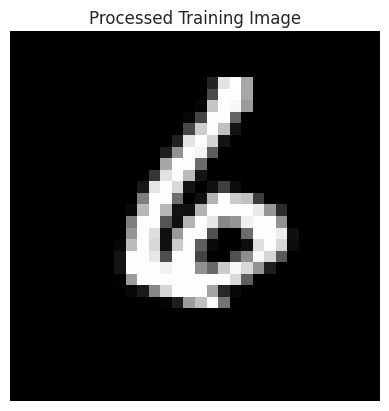

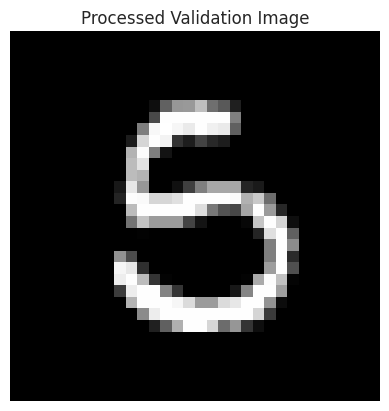

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy.ndimage import zoom

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def resize_image(image, new_size):
    # 计算缩放因子
    scale = [n / float(o) for n, o in zip(new_size, image.shape)]
    # 缩放图像
    return zoom(image, zoom=scale, order=1)

# 参数定义
train_num = 100
val_num = 20

# 读取训练图像
train_images = read_idx('MNIST/train/train-images.idx3-ubyte')

# 随机选择train_num个作为训练集，val_num个作为验证集
train_indices = np.random.choice(len(train_images), train_num, replace=False)
val_indices = np.random.choice(len(train_images), val_num, replace=False)

# 处理训练集和验证集图像
def process_images(indices, image_count):
    # 存储处理后的图像
    processed_images = []
    for index in indices[:image_count]:
        # 为图像添加0填充到32x32
        padded_image = np.pad(train_images[index], pad_width=2, mode='constant', constant_values=0)
        # 将图像大小调整为256x256
        #resized_image = resize_image(padded_image, (64, 64))
        processed_images.append(padded_image)
    return processed_images

# 获取处理后的训练集和验证集图像
processed_train_images = process_images(train_indices, train_num)
processed_val_images = process_images(val_indices, val_num)

# 示例：显示处理后的第一个训练集图像
plt.imshow(processed_train_images[0], cmap='gray')
plt.title('Processed Training Image')
plt.axis('off')  # 关闭坐标轴显示
plt.show()

# 示例：显示处理后的第一个验证集图像
plt.imshow(processed_val_images[0], cmap='gray')
plt.title('Processed Validation Image')
plt.axis('off')  # 关闭坐标轴显示
plt.show()


### Forward Model

In [8]:
Npat = 100 # nb of patterns on the SLM
Nslm = 1024  # nb of SLM pixels
Nfluo = 1024   # nb of beads
Ncam = 1024  # nb of camera pixels

magnitude = np.random.randn(Nfluo, Nslm)

# 使用模和相位创建复数矩阵
T1 = magnitude + 1j * magnitude
T1_t = to_complex_tensor(T1)

processed_train_images_flat = [img.reshape(-1) for img in processed_train_images]  # 展开每张图像
processed_val_images_flat = [img.reshape(-1) for img in processed_val_images]  # 展开每张图像

SLM_input_train = np.stack(processed_train_images_flat, axis=1)  # 沿着第二维（列）堆叠
SLM_input_val = np.stack(processed_val_images_flat, axis=1)  # 沿着第二维（列）堆叠

# 将 NumPy 数组转换为 PyTorch 张量
SLM_input_train_pha = torch.from_numpy(SLM_input_train).float().to(device)
SLM_input_train_t = phase_to_complex(SLM_input_train_pha)

SLM_input_val_pha = torch.from_numpy(SLM_input_val).float().to(device)
SLM_input_val_t = phase_to_complex(SLM_input_val_pha)

field1_train_t = complex_matmul(T1_t, SLM_input_train_t)
int1_train_t = torch.sum(torch.abs(field1_train_t)**2,-1)

field1_val_t = complex_matmul(T1_t, SLM_input_val_t)
int1_val_t = torch.sum(torch.abs(field1_val_t)**2,-1)
# int1_val_t = int1_val_t.T
# CAM_output_t = T2_t@int1_t

In [9]:
torch.save(T1_t.cpu(), 'MNIST/train/T1.npy')

In [10]:
import os

# SLM_input_train 是一个 NumPy 数组
np.save('MNIST/train/train_image.npy', SLM_input_train)

# int1_train_t 是一个 PyTorch 张量
# 保存前确保它在 CPU 上，因为张量需要在 CPU 上才能转换为 NumPy 数组
torch.save(int1_train_t.cpu(), 'MNIST/train/train_speckle.npy')

In [11]:
# SLM_input_train 是一个 NumPy 数组
np.save('MNIST/val/val_image.npy', SLM_input_val)

# int1_train_t 是一个 PyTorch 张量
# 保存前确保它在 CPU 上，因为张量需要在 CPU 上才能转换为 NumPy 数组
torch.save(int1_val_t.cpu(), 'MNIST/val/val_speckle.npy')

In [12]:
array = np.load('MNIST/train/train_image.npy')

# 打印数组的尺寸
print(int1_train_t)
max_element = torch.max(int1_train_t)
min_element = torch.min(int1_train_t)

print("最大元素:", max_element.item())
print("最小元素:", min_element.item())
print("Shape of the array:", array.shape)

tensor([[1258.5500, 1527.2573, 3248.1470,  ...,  477.7973,  314.8382,
         2358.1243],
        [2026.7856, 2901.2183, 5573.2583,  ...,  943.0797, 1949.3379,
         3353.0889],
        [   9.9802, 1765.2131, 1101.8501,  ...,  500.4116,  282.1110,
           13.5976],
        ...,
        [ 224.9018, 1656.2825,  668.6889,  ...,  886.4269,  976.3826,
          761.7306],
        [ 452.7928, 1987.4495, 1574.1560,  ...,  818.0706,  269.1413,
         1075.8264],
        [ 668.7312, 4103.6792, 2103.4045,  ...,  810.0176, 1021.2811,
         3001.4690]], device='cuda:0')
最大元素: 34308.25
最小元素: 0.0037708450108766556
Shape of the array: (1024, 100)


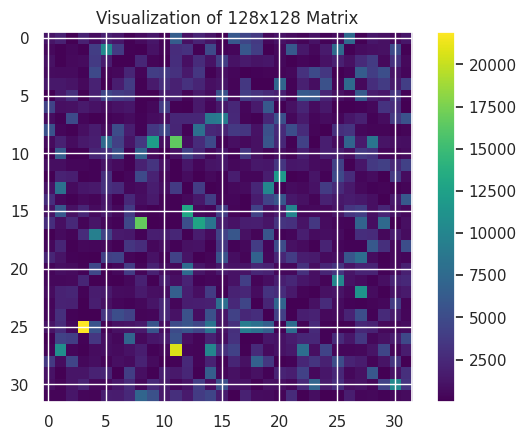

In [13]:
first_row = int1_train_t.T.cpu()[0, :]  # 假设数据存储为行向量
matrix_128x128 = first_row.reshape((32, 32))

# 使用matplotlib生成图像
plt.imshow(matrix_128x128, cmap='viridis', interpolation='none')
plt.colorbar()  # 添加颜色条
plt.title('Visualization of 128x128 Matrix')
plt.show()

Saved 100 images to data/train/input


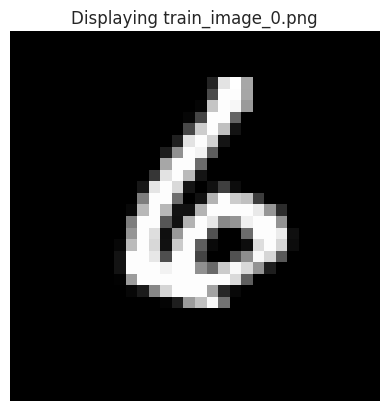

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# 确保目标文件夹存在
output_dir = 'data/train/input'
os.makedirs(output_dir, exist_ok=True)

# 将每个处理后的验证集图像保存为.tif文件
for idx, img in enumerate(processed_train_images):
    # 转换图像数据类型为uint8，适合保存图像文件
    img = (img - img.min()) / (img.max() - img.min())  # 归一化到0-1
    img = (img * 255).astype(np.uint8)  # 缩放到0-255

    # 创建图像对象
    image = Image.fromarray(img)
    # 构建文件路径
    file_path = os.path.join(output_dir, f'train_image_{idx}.png')
    # 保存为.tif文件
    image.save(file_path)

print(f"Saved {len(processed_train_images)} images to {output_dir}")

file_name = 'train_image_0.png'  # 假设我们要查看的是第一个图像
file_path = os.path.join(output_dir, file_name)

# 加载图像
image = Image.open(file_path)

# 显示图像
plt.imshow(image, cmap='gray')  # 使用灰度色图显示
plt.title(f'Displaying {file_name}')
plt.axis('off')  # 不显示坐标轴
plt.show()

Saved 20 images to data/val/input


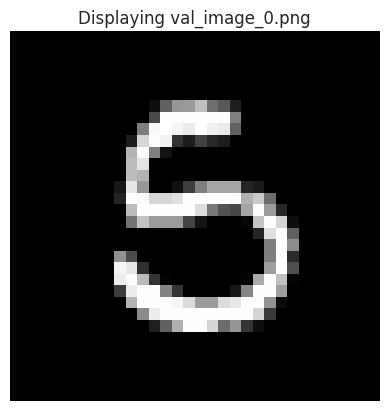

In [15]:
# 确保目标文件夹存在
output_dir = 'data/val/input'
os.makedirs(output_dir, exist_ok=True)

# 将每个处理后的验证集图像保存为.tif文件
for idx, img in enumerate(processed_val_images):
    # 转换图像数据类型为uint8，适合保存图像文件
    img = (img - img.min()) / (img.max() - img.min())  # 归一化到0-1
    img = (img * 255).astype(np.uint8)  # 缩放到0-255

    # 创建图像对象
    image = Image.fromarray(img)
    # 构建文件路径
    file_path = os.path.join(output_dir, f'val_image_{idx}.png')
    # 保存为.tif文件
    image.save(file_path)

print(f"Saved {len(processed_val_images)} images to {output_dir}")

file_name = 'val_image_0.png'  # 假设我们要查看的是第一个图像
file_path = os.path.join(output_dir, file_name)

# 加载图像
image = Image.open(file_path)

# 显示图像
plt.imshow(image, cmap='gray')  # 使用灰度色图显示
plt.title(f'Displaying {file_name}')
plt.axis('off')  # 不显示坐标轴
plt.show()

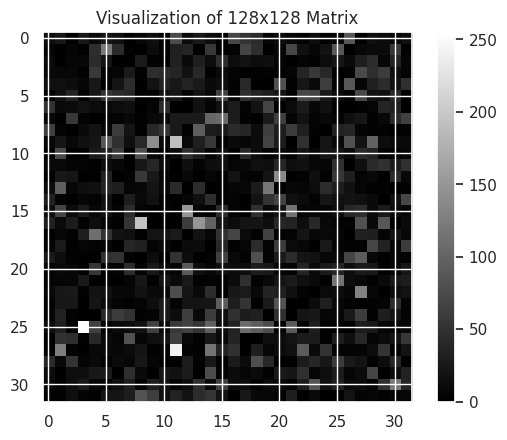

In [16]:
import torch
import matplotlib.pyplot as plt
import os

# 加载数据（使用torch.load，因为文件是用torch.save保存的）
speckle_data = torch.load('MNIST/train/train_speckle.npy')

# 确保输出目录存在
output_dir = 'data/train/output'
os.makedirs(output_dir, exist_ok=True)

# 转换并保存图像
for i in range(speckle_data.shape[1]):  # 遍历所有列
    # 从列向量转换成128x128图像
    image = speckle_data[:, i].reshape(32, 32).numpy()  # 转换为NumPy数组
    
    # 归一化到0-1
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # 缩放到0-255并转换为整数
    image_scaled = (image_normalized * 255).astype(np.uint8)
    
    # 生成输出文件名
    output_filename = os.path.join(output_dir, f'train_speckle_{i}.png')
    
    # 保存图像
    
    plt.imsave(output_filename, image_scaled, cmap='gray')

file_name = 'train_speckle_0.png'  # 假设我们要查看的是第一个图像
file_path = os.path.join(output_dir, file_name)

# 加载图像
image = Image.open(file_path)

# 显示图像
plt.imshow(image, cmap='gray', interpolation='none')
plt.colorbar()  # 添加颜色条
plt.title('Visualization of 128x128 Matrix')
plt.show()


In [19]:
max_element = torch.max(image)
min_element = torch.min(image)

print("最大元素:", max_element.item())
print("最小元素:", min_element.item())

TypeError: max(): argument 'input' (position 1) must be Tensor, not PngImageFile

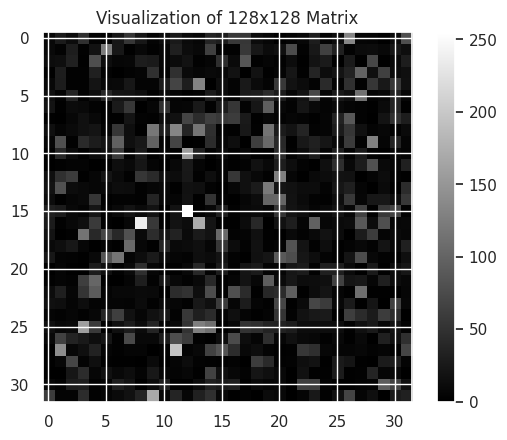

In [17]:
# 加载数据（使用torch.load，因为文件是用torch.save保存的）
speckle_data = torch.load('MNIST/val/val_speckle.npy')

# 确保输出目录存在
output_dir = 'data/val/output'
os.makedirs(output_dir, exist_ok=True)

# 转换并保存图像
for i in range(speckle_data.shape[1]):  # 遍历所有列
    # 从列向量转换成128x128图像
    image = speckle_data[:, i].reshape(32, 32).numpy()  # 转换为NumPy数组
    
    # 归一化到0-1
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # 缩放到0-255并转换为整数
    image_scaled = (image_normalized * 255).astype(np.uint8)
    
    # 生成输出文件名
    output_filename = os.path.join(output_dir, f'val_speckle_{i}.png')
    
    # 保存图像
    
    plt.imsave(output_filename, image_scaled, cmap='gray')

file_name = 'val_speckle_0.png'  # 假设我们要查看的是第一个图像
file_path = os.path.join(output_dir, file_name)

# 加载图像
image = Image.open(file_path)

# 显示图像
plt.imshow(image, cmap='gray', interpolation='none')
plt.colorbar()  # 添加颜色条
plt.title('Visualization of 128x128 Matrix')
plt.show()

# Noise

In [19]:
import os
import shutil

# Directory to be cleared
dir_path = 'data/train/noised_gaussian_150_L'

# Check if the directory exists
if os.path.exists(dir_path):
    # Remove all files and folders in the directory
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
else:
    print(f'The directory {dir_path} does not exist.')


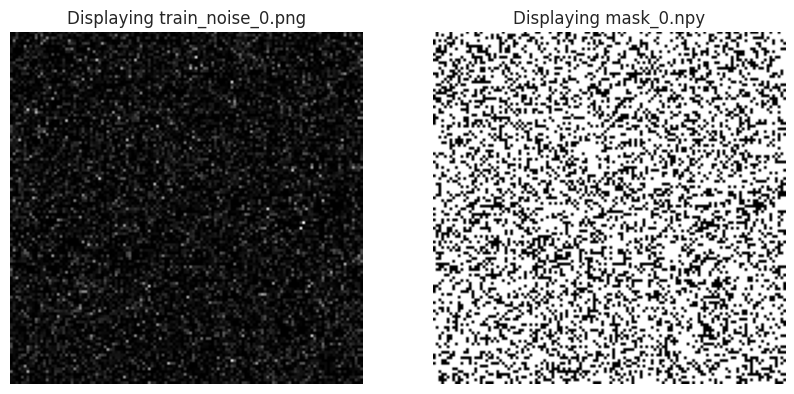

In [38]:
import numpy as np
import os
from PIL import Image

# Noise probability
p = 0.3

# Input and output directories
input_dir = 'data/train/output'
output_dir = 'data/train/noised_03'
mask_dir = os.path.join(output_dir, 'masks')
os.makedirs(output_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Get all image files
image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Process each image
for filename in image_files:
    # Read the image and convert to grayscale
    img_path = os.path.join(input_dir, filename)
    image = np.array(Image.open(img_path).convert('L'))  # 'L' mode for grayscale
    
    # Create a random matrix and apply noise
    mask = np.random.rand(*image.shape) < p
    noised_image = image.copy()
    noised_image[mask] = 0
    
    # Save the processed image
    output_img_path = os.path.join(output_dir, f'train_noise_{filename.split("_")[-1]}')
    Image.fromarray(noised_image).save(output_img_path)
    
    # Save the mask (0 where noise was added, 1 elsewhere)
    mask_save = np.where(mask, 0, 1)
    mask_filename = f'mask_{filename.split("_")[-1]}'
    mask_filename = mask_filename.replace('.png', '.npy')
    mask_img_path = os.path.join(mask_dir, mask_filename)
    np.save(mask_img_path, mask_save)  # Save the mask as a numpy array

# Assuming we want to display the first image and its mask
file_name = 'train_noise_0.png'
mask_name = 'mask_0.npy'
file_path = os.path.join(output_dir, file_name)
mask_path = os.path.join(mask_dir, mask_name)

# Load the image and the mask
image = Image.open(file_path)
mask = np.load(mask_path)  # Load the mask numpy array

# Display the image and the mask
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Displaying {file_name}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')  # Mask might look fully white if most values are 1
plt.title(f'Displaying {mask_name}')
plt.axis('off')

plt.show()


In [22]:
print(field1_train_t)

tensor([[[ -22.7992,   42.4218],
         [  43.1261,  -12.3716],
         [  39.6698,   93.2931],
         ...,
         [  50.5617,   -7.3999],
         [  66.4908,   24.7758],
         [  41.9893,   45.7384]],

        [[-120.1078,  -98.8311],
         [ -66.4193,  -27.1600],
         [ -63.7130, -107.2133],
         ...,
         [-117.2449, -112.9244],
         [ -10.9952,   29.8457],
         [ -45.6985,  -67.1393]],

        [[ -67.0230, -110.0220],
         [-112.0539,  -60.5872],
         [-134.2476,  -40.7433],
         ...,
         [-132.6274, -112.4852],
         [-105.0617, -169.1724],
         [ -50.6083,  -87.0368]],

        ...,

        [[ -84.9451,  -34.6340],
         [  -5.7094,  -69.0108],
         [ -64.7797,  -90.1491],
         ...,
         [-112.8177,  -23.9786],
         [  -6.0394,  -77.8472],
         [ -12.0033,   14.4947]],

        [[ -89.0768,  -51.9661],
         [ -82.1534,  -53.6680],
         [ -23.5818,  -46.7206],
         ...,
         [ -36.81

In [18]:
import torch
import numpy as np
import os
import cv2
from PIL import Image
import scipy.io as sio

# Make sure field1_train_t data is loaded
# field1_train_t = torch.from_numpy(np.load('path_to_field1_train_t.npy')).to(torch.float32).to('cuda')  # Adjust based on your device

def add_gaussian_noise_and_complex_adjust(img, field_column, model_path, sigma):
    img = torch.from_numpy(img).to(torch.float32).to('cuda')  # Convert image to PyTorch tensor and move to GPU
    print(img[1, :])
    index = model_path.rfind("/")
    if sigma > 0:
        noise = torch.normal(mean=0.0, std=sigma / 255., size=img.size(), device='cuda')
        #noise = torch.clamp(noise, -0.5, 0.5)
        print(noise[1, :])
        sio.savemat(model_path[:index] + '/noise.mat', {'noise': noise.cpu().numpy()})  # Save noise to file
        noisy_img = img + noise
    else:
        noisy_img = img

    max_value = torch.max(img)  # 获取 noisy_img 中的最大值
    noisy_img_clipped = torch.clamp(noisy_img, 0, max_value).to(torch.uint8)
    print(noisy_img_clipped[1, :])
    cv2.imwrite(model_path[:index] + '/noisy.png', noisy_img_clipped.cpu().numpy().squeeze())  # Save noisy image to file
    
    # Adjust the complex field based on noise
    field = field_column.reshape(32, 32, 2).to(torch.float32).to('cuda')
    intensity = torch.sum(torch.abs(field) ** 2, dim=-1)
    new_intensity = intensity + noise.reshape(32, 32)
    
    magnitude = torch.sqrt(new_intensity)
    phase = torch.atan2(field[:,:,1], field[:,:,0])
    new_field = torch.stack((magnitude * torch.cos(phase), magnitude * torch.sin(phase)), dim=-1)
    
    return noisy_img.cpu().numpy(), new_field.cpu().numpy()  # Move results to CPU and convert to NumPy

# Configure the noise parameters and directories
sigma = 150  # Standard deviation for Gaussian noise
input_dir = 'data/train/output'
output_dir = 'data/train/noised_gaussian_150_L'
output_complex_dir = 'data/train/output_complex'
noise_dir = os.path.join(output_dir, 'noise_matrices')
os.makedirs(output_dir, exist_ok=True)
os.makedirs(noise_dir, exist_ok=True)
os.makedirs(output_complex_dir, exist_ok=True)

# Process each image file
image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
for idx, filename in enumerate(image_files):
    img_path = os.path.join(input_dir, filename)
    image = np.array(Image.open(img_path).convert('L'), dtype=np.float32)  # Load image and convert to grayscale
    model_path = os.path.join(noise_dir, filename)
    noised_image, new_field = add_gaussian_noise_and_complex_adjust(image, field1_train_t[:, idx, :], model_path, sigma)
    
    # Save the processed image and complex field
    output_img_path = os.path.join(output_dir, f'gaussian_noised_{filename}')
    Image.fromarray(noised_image.astype(np.uint8)).save(output_img_path)
    np.save(os.path.join(output_complex_dir, f'complex_{filename[:-4]}.npy'), new_field)

print("Gaussian noise added to all images and new complex matrices saved.")


tensor([  1.,  12.,   2.,  12.,  38., 130.,  25.,   2.,   0.,  15.,   0.,  36.,
         23.,  26., 101.,   4.,   5.,  81.,  10.,   1.,  14.,  20.,   8.,   0.,
         20.,  36.,   0.,  13.,   5.,   7.,   7.,   1.], device='cuda:0')
tensor([ 0.3739, -0.1710,  0.8352,  0.5178,  0.3894, -0.2235,  0.3061, -1.3840,
        -0.7431,  0.2754,  0.5288, -0.1507,  0.6812,  0.4781, -0.5040,  0.3282,
        -0.8589, -0.3873,  0.4605,  1.0453, -0.3888, -0.2126,  0.0960,  0.0535,
         1.2716,  0.7727, -0.5782, -0.3264, -0.2098,  0.5530, -0.7005, -0.4189],
       device='cuda:0')
tensor([  1,  11,   2,  12,  38, 129,  25,   0,   0,  15,   0,  35,  23,  26,
        100,   4,   4,  80,  10,   2,  13,  19,   8,   0,  21,  36,   0,  12,
          4,   7,   6,   0], device='cuda:0', dtype=torch.uint8)
tensor([  2.,  10.,   4.,   2.,  56.,  95.,  39.,   1.,   6.,  14.,   4.,  40.,
         29.,  12.,  34.,   6.,   0.,  39.,   8.,   3.,   1.,  88.,   5.,   7.,
         15., 125.,   2.,  26.,  15.,  1

In [20]:
import torch
import numpy as np
import os
import cv2
from PIL import Image
import scipy.io as sio

def add_gaussian_noise_and_complex_adjust(img, field_column, base_path, sigma, noise_count=10):
    img_tensor = torch.from_numpy(img).to(torch.float32).to('cuda')
    noise_list = []
    
    # Create directories for each noise mask
    noise_dirs = [os.path.join(base_path, str(i + 1)) for i in range(noise_count)]
    for dir_path in noise_dirs:
        os.makedirs(dir_path, exist_ok=True)

    for i, noise_dir in enumerate(noise_dirs):
        noise = torch.normal(mean=0.0, std=sigma / 255., size=img_tensor.size(), device='cuda')
        noise_list.append(noise)
        noisy_img = img_tensor + noise
        noisy_img_clipped = torch.clamp(noisy_img, 0, 255).to(torch.uint8)
        cv2.imwrite(os.path.join(noise_dir, 'noisy.png'), noisy_img_clipped.cpu().numpy().squeeze())

    # Compute and handle the average noise
    average_noise = torch.mean(torch.stack(noise_list), dim=0)
    sio.savemat(base_path + '/average_noise.mat', {'noise': average_noise.cpu().numpy()})
    noisy_img_avg = img_tensor + average_noise
    noisy_img_avg_clipped = torch.clamp(noisy_img_avg, 0, 255).to(torch.uint8)
    cv2.imwrite(os.path.join(base_path, 'average_noised.png'), noisy_img_avg_clipped.cpu().numpy().squeeze())

    # Adjust the complex field based on average noise
    field = field_column.reshape(32, 32, 2).to(torch.float32).to('cuda')
    intensity = torch.sum(torch.abs(field) ** 2, dim=-1)
    new_intensity = intensity + average_noise.reshape(32, 32)
    magnitude = torch.sqrt(new_intensity)
    phase = torch.atan2(field[:, :, 1], field[:, :, 0])
    new_field = torch.stack((magnitude * torch.cos(phase), magnitude * torch.sin(phase)), dim=-1)

    return noisy_img_avg_clipped.cpu().numpy(), new_field.cpu().numpy()

sigma = 150  # Standard deviation for Gaussian noise
input_dir = 'data/train/output'
output_dir = 'data/train/noised_gaussian_150_L'
output_complex_dir = 'data/train/output_complex'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_complex_dir, exist_ok=True)

image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
for idx, filename in enumerate(image_files):
    img_path = os.path.join(input_dir, filename)
    image = np.array(Image.open(img_path).convert('L'), dtype=np.float32)
    base_path = os.path.join(output_dir, filename[:-4])  # Remove '.png' and use as base path
    noised_image_avg, new_field = add_gaussian_noise_and_complex_adjust(image, field1_train_t[:, idx, :], base_path, sigma)
    
    # Save the average noised image and complex field
    output_img_path = os.path.join(output_dir, f'average_gaussian_noised_{filename}')
    Image.fromarray(noised_image_avg.astype(np.uint8)).save(output_img_path)
    np.save(os.path.join(output_complex_dir, f'complex_avg_{filename[:-4]}.npy'), new_field)

print("Gaussian noise added to all images with multiple masks and averaged. New complex matrices saved.")


Gaussian noise added to all images with multiple masks and averaged. New complex matrices saved.


In [51]:
import numpy as np
import os
from PIL import Image
import cv2
import scipy.io as sio

def add_poisson_noise(img, model_path, lam):
    index = model_path.rfind("/")
    lam = lam / 255
    # 泊松分布生成噪声，lambda为lam，lam大则噪声强度大
    if lam > 0:
        noise = np.random.poisson(lam, size=img.shape).astype(np.float32) - lam
        print(noise[1, :])
        sio.savemat(model_path[0:index] + '/noise.mat', {'noise': noise})
        noisy_img = img + noise
    else:
        noisy_img = img.astype(np.float32)
    cv2.imwrite(model_path[0:index] + '/noisy.png', np.squeeze(np.int32(np.clip(noisy_img, 0, 255))))
    return noisy_img

# Noise parameters
lam = 240  # Lambda parameter for the Poisson distribution

# Input and output directories
input_dir = 'data/val/output'
output_dir = 'data/train/noised_poisson_240'
noise_dir = os.path.join(output_dir, 'noise_matrices')
os.makedirs(output_dir, exist_ok=True)
os.makedirs(noise_dir, exist_ok=True)

# Get all image files
image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Process each image
for filename in image_files:
    # Read the image
    img_path = os.path.join(input_dir, filename)
    image = np.array(Image.open(img_path).convert('L'), dtype=np.float32)  # Convert image to grayscale for simplicity
    
    # Model path for saving noise matrix and noisy image
    model_path = os.path.join(noise_dir, filename)
    
    # Add Poisson noise to the image
    noised_image = add_poisson_noise(image, model_path, lam)
    
    # Save the processed image
    output_img_path = os.path.join(output_dir, f'poisson_noised_{filename}')
    Image.fromarray(np.uint8(noised_image)).save(output_img_path)

print("Poisson noise added to all images and saved.")


[ 0.05882353  0.05882353 -0.9411765   0.05882353  1.0588236   2.0588236
  1.0588236   1.0588236  -0.9411765  -0.9411765   0.05882353  0.05882353
 -0.9411765  -0.9411765   0.05882353  1.0588236  -0.9411765   0.05882353
 -0.9411765   1.0588236   1.0588236   3.0588236  -0.9411765   0.05882353
  1.0588236  -0.9411765  -0.9411765   0.05882353  0.05882353  0.05882353
  3.0588236   3.0588236   0.05882353 -0.9411765  -0.9411765  -0.9411765
  0.05882353 -0.9411765  -0.9411765   0.05882353 -0.9411765  -0.9411765
 -0.9411765   1.0588236  -0.9411765  -0.9411765   1.0588236  -0.9411765
 -0.9411765  -0.9411765   0.05882353  2.0588236   0.05882353  1.0588236
  0.05882353  0.05882353 -0.9411765  -0.9411765  -0.9411765  -0.9411765
 -0.9411765  -0.9411765   1.0588236  -0.9411765 ]
[ 2.0588236   0.05882353  0.05882353  0.05882353 -0.9411765   0.05882353
 -0.9411765  -0.9411765   0.05882353  0.05882353 -0.9411765   0.05882353
  2.0588236  -0.9411765  -0.9411765   0.05882353  1.0588236   0.05882353
  0.058

# Corr

In [28]:
import numpy as np

# 指定文件路径
#file_path = 'data/train/output_corr_0/complex_train_speckle_0.npy'
file_path = 'MNIST/train/train_speckle.npy'


# 加载.npy文件
data = torch.load(file_path)

# 打印数据的形状和数据类型
print("Shape of the data:", data.shape)
print("Data type of the data:", data.dtype)
# 打印前几个元素来查看数据内容
print("First few elements of the data:", data)


Shape of the data: torch.Size([4096, 100])
Data type of the data: torch.float32
First few elements of the data: tensor([[2.0998e+03, 3.6404e+03, 1.7398e+02,  ..., 1.7332e+03, 1.3623e+03,
         4.2411e+03],
        [4.7593e+03, 1.3735e+03, 6.0434e+02,  ..., 8.5172e+03, 1.7583e+03,
         3.7399e+03],
        [1.5961e+03, 3.4990e+03, 3.5591e+03,  ..., 1.6999e+03, 9.9231e+02,
         6.8954e+01],
        ...,
        [3.6999e+04, 3.1729e+04, 1.7959e+04,  ..., 4.1354e+04, 3.1945e+04,
         1.7314e+04],
        [1.7214e+03, 3.3770e+03, 4.8935e+03,  ..., 5.7261e+03, 3.0504e-01,
         1.5222e+03],
        [5.3505e+03, 2.2196e+04, 2.1764e+04,  ..., 1.5412e+04, 8.3949e+03,
         4.5853e+03]])


In [31]:
import numpy as np
import os

def compute_mu(field):
    N = field.shape[0]
    M = field.shape[1]
    mu = np.zeros((N, M), dtype=np.float32)  # 初始化mu矩阵为float类型

    for i in range(N):
        for j in range(M):
            if i == j:
                continue  # 对角线元素设为0
            R_i, L_i = field[i, j, 0], field[i, j, 1]
            R_j, L_j = field[j, i, 0], field[j, i, 1]
            
            # 计算模
            numerator = R_i * R_j + L_i * L_j
            denominator = np.sqrt((R_i**2 + L_i**2) * (R_j**2 + L_j**2))
            if denominator != 0:
                mu[i, j] = numerator / denominator
    
    return mu

# 加载.npy文件
input_dir = 'data/train/output_complex'
output_dir = 'data/train/output_corr_0'
os.makedirs(output_dir, exist_ok=True)

# 处理所有.npy文件
for filename in os.listdir(input_dir):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_dir, filename)
        complex_field = np.load(file_path)
        
        # 计算模的矩阵
        mu_matrix = compute_mu(complex_field.reshape(128, 128, 2))  # 确保复数场的shape正确
        
        # 保存结果
        output_file_path = os.path.join(output_dir, filename)
        np.save(output_file_path, mu_matrix)

print("Correlation matrices (mu values) have been calculated and saved.")


Correlation matrices (mu values) have been calculated and saved.


# Without Diag

In [20]:
import numpy as np
import os
import cupy as cp

def compute_mu(field):
    N = field.shape[0] * field.shape[1]  # 总共的元素数量
    flat_field = field.reshape(N, 2)  # 将矩阵展平
    flat_field = cp.asarray(flat_field)
    
    # 初始化比原始矩阵少一列的数组
    mu = cp.zeros((N, N - 1), dtype=cp.float32)
    
    # 计算相关系数
    for i in range(N):
        print(i)
        k = 0  # 新的列索引
        for j in range(N):
            if i != j:
                R_i, L_i = flat_field[i]
                R_j, L_j = flat_field[j]
                
                numerator = R_i * R_j + L_i * L_j
                denominator = cp.sqrt((R_i**2 + L_i**2) * (R_j**2 + L_j**2))
                if denominator != 0:
                    mu[i, k] = numerator / denominator
                k += 1
    
    # 将结果从GPU内存转回到主机内存
    mu = cp.asnumpy(mu)
    return mu

# 加载.npy文件
input_dir = 'data/train/output_complex_0'
output_dir = 'data/train/output_corr_0'
os.makedirs(output_dir, exist_ok=True)

# 处理所有.npy文件
for filename in os.listdir(input_dir):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_dir, filename)
        complex_field = np.load(file_path)
        complex_field = cp.asarray(complex_field)
        
        # 计算模的矩阵
        mu_matrix = compute_mu(complex_field.reshape(32, 32, 2))  # 确保复数场的shape正确
        
        # 保存结果
        output_file_path = os.path.join(output_dir, filename)
        np.save(output_file_path, mu_matrix)

print("Correlation matrices (mu values) have been calculated and saved.")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Diag

In [22]:
import numpy as np
import os

import cupy as cp

def compute_mu(field):
    N = field.shape[0] * field.shape[1]  # 总共的元素数量
    flat_field = field.reshape(N, 2)  # 将矩阵展平

    # 使用GPU数组
    flat_field = cp.asarray(flat_field)
    mu = cp.zeros((N, N), dtype=cp.float32)
    
    # 对角线元素设为1
    cp.fill_diagonal(mu, 1)

    # 计算两两元素之间的相关系数
    for i in range(N):
        print(i)
        for j in range(i+1, N):  # 只计算上三角矩阵
            R_i, L_i = flat_field[i]
            R_j, L_j = flat_field[j]
            
            numerator = R_i * R_j + L_i * L_j
            denominator = cp.sqrt((R_i**2 + L_i**2) * (R_j**2 + L_j**2))
            if denominator != 0:
                mu[i, j] = mu[j, i] = numerator / denominator
    
    # 将结果从GPU内存转回到主机内存
    mu = cp.asnumpy(mu)
    return mu

# 加载.npy文件
input_dir = 'data/train/output_complex_0'
output_dir = 'data/train/output_corr_00'
os.makedirs(output_dir, exist_ok=True)

# 处理所有.npy文件
for filename in os.listdir(input_dir):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_dir, filename)
        complex_field = np.load(file_path)
        complex_field = cp.asarray(complex_field)
        
        # 计算模的矩阵
        mu_matrix = compute_mu(complex_field.reshape(32, 32, 2))  # 确保复数场的shape正确
        
        # 保存结果
        output_file_path = os.path.join(output_dir, filename)
        np.save(output_file_path, mu_matrix)

print("Correlation matrices (mu values) have been calculated and saved.")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Prob

In [60]:
import numpy as np
import os
from PIL import Image
from scipy.special import i0  # Bessel function of the first kind

def process_image(file_path):
    img = Image.open(file_path).convert('L')  # 转换为灰度图
    img_array = np.array(img)
    print("Original image shape:", img_array.shape)  # 打印原始图像的尺寸
    
    # 去除偶数列
    processed_array = img_array[:, 1::2]
    processed_array = np.clip(processed_array, 1e-8, 255)
    # 展平成向量
    flattened_vector = processed_array.flatten()
    print("Processed image shape:", processed_array.shape)  # 打印处理后的图像尺寸
    print("Flattened vector length:", len(flattened_vector))  # 打印展平向量的长度
    return flattened_vector

def process_matrix(file_path):
    # 加载.npy文件
    matrix = np.load(file_path)
    
    # 去除奇数列和偶数行
    processed_matrix = matrix[1::2, ::2]
    print("Processed matrix shape:", processed_matrix.shape)

    # 将值限制在 (-1 + 1e-8, 1 - 1e-8) 范围内
    lower_bound = -1 + 1e-8
    upper_bound = 1 - 1e-8
    processed_matrix = np.clip(processed_matrix, lower_bound, upper_bound)
    
    return processed_matrix

def calculate_probability(vector, matrix):
    probabilities = []
    
    for i, I_i in enumerate(vector):
        M_i = matrix[i, :]  # 第i行
        numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))
        denominator = I_i * (1 - M_i**2)
            
        p_i_M = numerator / denominator
        p_i_M[np.isinf(p_i_M)] = np.nan
        #print(p_i_M)
        p_i_M = np.clip(p_i_M, -1, 1)
        p_i_M_avg = np.nanmean(p_i_M)  # 第i行的平均条件概率，忽略NaN和inf
        probabilities.append(p_i_M_avg)
    
    return np.nanmean(probabilities)  # 向量上的平均概率，忽略NaN和inf


image_dir = 'data/train/output_temp'
matrix_dir = 'data/train/output_corr'
results = []
   
# 获取前十个.png图像文件
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
matrix_files = sorted([f for f in os.listdir(matrix_dir) if f.endswith('.npy')])
    
# 匹配图像文件和.npy文件
matches = {img_file: None for img_file in image_files}
for img_file in image_files:
    index = img_file.split('_')[-1].split('.')[0]  # 获取_k后的序号
    for mat_file in matrix_files:
        if mat_file.endswith(f'_{index}.npy'):
            matches[img_file] = mat_file
            break
    
for img_file, mat_file in matches.items():
    vector = process_image(os.path.join(image_dir, img_file))
    matrix = process_matrix(os.path.join(matrix_dir, mat_file))
        
    probability = calculate_probability(vector, matrix)
    results.append(probability)

for result in results:
    print(result)


Original image shape: (64, 64)
Processed image shape: (64, 32)
Flattened vector length: 2048
Processed matrix shape: (2048, 2048)


/tmp/ipykernel_258/2222016788.py:40: RuntimeWarning: divide by zero encountered in true_divide
  numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))
/tmp/ipykernel_258/2222016788.py:40: RuntimeWarning: invalid value encountered in multiply
  numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))


Original image shape: (64, 64)
Processed image shape: (64, 32)
Flattened vector length: 2048
Processed matrix shape: (2048, 2048)
Original image shape: (64, 64)
Processed image shape: (64, 32)
Flattened vector length: 2048
Processed matrix shape: (2048, 2048)
0.1942667
0.23392284
0.2225957


In [27]:
import numpy as np
import os
from PIL import Image
from scipy.special import i0  # Bessel function of the first kind

def process_image(file_path):
    img = Image.open(file_path).convert('L')  # 转换为灰度图
    img_array = np.array(img)
    print("Original image shape:", img_array.shape)  # 打印原始图像的尺寸
    
    # 去除偶数列
    processed_array = img_array[:, 1::2]
    processed_array = np.clip(processed_array, 1e-8, 255)
    # 展平成向量
    flattened_vector = processed_array.flatten()
    print("Processed image shape:", processed_array.shape)  # 打印处理后的图像尺寸
    print("Flattened vector length:", len(flattened_vector))  # 打印展平向量的长度
    return flattened_vector

def process_matrix(file_path):
    # 加载.npy文件
    matrix = np.load(file_path)
    
    # 去除奇数列和偶数行
    processed_matrix = matrix[1::2, ::2]
    print("Processed matrix shape:", processed_matrix.shape)

    # 将值限制在 (-1 + 1e-8, 1 - 1e-8) 范围内
    lower_bound = -1 + 1e-8
    upper_bound = 1 - 1e-8
    processed_matrix = np.clip(processed_matrix, lower_bound, upper_bound)
    
    return processed_matrix

def calculate_probability(vector, matrix):
    probabilities = []
    
    for i, I_i in enumerate(vector):
        M_i = matrix[i, :]  # 第i行
        numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))
        denominator = I_i * (1 - M_i**2)
            
        p_i_M = numerator / denominator
        p_i_M[np.isinf(p_i_M)] = np.nan
        p_i_M = np.clip(p_i_M, -1, 1)
        p_i_M_avg = np.nanmean(p_i_M)  # 第i行的平均条件概率，忽略NaN和inf
        probabilities.append(p_i_M_avg)
    
    return np.nanmean(probabilities)  # 向量上的平均概率，忽略NaN和inf


image_dir = 'data/train/avgnoise_pred'
matrix_dir = 'data/train/output_corr_0'
results = []
   
# 获取前十个.png图像文件
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
matrix_files = sorted([f for f in os.listdir(matrix_dir) if f.endswith('.npy')])
    
# 匹配图像文件和.npy文件
matches = {img_file: None for img_file in image_files}
for img_file in image_files:
    index = img_file.split('_')[-1].split('.')[0]  # 获取_k后的序号
    for mat_file in matrix_files:
        if mat_file.endswith(f'_{index}.npy'):
            matches[img_file] = mat_file
            break
    
for img_file, mat_file in matches.items():
    vector = process_image(os.path.join(image_dir, img_file))
    matrix = process_matrix(os.path.join(matrix_dir, mat_file))
        
    probability = calculate_probability(vector, matrix)
    results.append((img_file, probability))  # 保存图片名和对应的概率

for img_name, result in results:
    print(f"{img_name}: {result}")


Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)


/tmp/ipykernel_255/3117896885.py:40: RuntimeWarning: invalid value encountered in multiply
  numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))
/tmp/ipykernel_255/3117896885.py:40: RuntimeWarning: divide by zero encountered in true_divide
  numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))


Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix sh

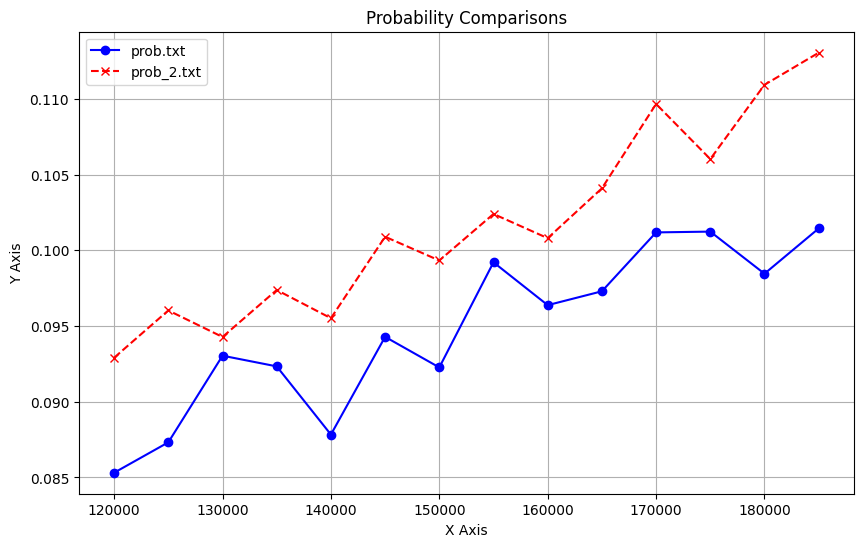

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 加载数据
data1 = np.loadtxt('prob.txt', delimiter=',')
data2 = np.loadtxt('prob_2.txt', delimiter=',')

x = data1[:, 0]  # 第一列作为x轴，假设prob.txt和prob_2.txt的x轴是相同的
y1 = data1[:, 1]  # 第二列作为y轴
y2 = data2[:, 1]  # 第二列作为y轴

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(x, y1, marker='o', linestyle='-', color='blue', label='prob.txt')
plt.plot(x, y2, marker='x', linestyle='--', color='red', label='prob_2.txt')
plt.title('Probability Comparisons')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.grid(True)
plt.legend()
plt.show()


In [2]:
import numpy as np
import os
from PIL import Image
from scipy.special import i0  # Bessel function of the first kind

def process_image(file_path):
    img = Image.open(file_path).convert('L')  # 转换为灰度图
    img_array = np.array(img)
    print("Original image shape:", img_array.shape)  # 打印原始图像的尺寸
    
    # 去除偶数列
    processed_array = img_array[:, 1::2]
    processed_array = np.clip(processed_array, 1e-8, 255)
    # 展平成向量
    flattened_vector = processed_array.flatten()
    print("Processed image shape:", processed_array.shape)  # 打印处理后的图像尺寸
    print("Flattened vector length:", len(flattened_vector))  # 打印展平向量的长度
    return flattened_vector

def process_matrix(file_path):
    # 加载.npy文件
    matrix = np.load(file_path)
    
    # 去除奇数列和偶数行
    processed_matrix = matrix[1::2, ::2]
    print("Processed matrix shape:", processed_matrix.shape)

    # 将值限制在 (-1 + 1e-8, 1 - 1e-8) 范围内
    lower_bound = -1 + 1e-8
    upper_bound = 1 - 1e-8
    processed_matrix = np.clip(processed_matrix, lower_bound, upper_bound)
    
    return processed_matrix

def calculate_probability(vector, matrix):
    probabilities = []
    
    for i, I_i in enumerate(vector):
        M_i = matrix[i, :]  # 第i行
        numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))
        denominator = I_i * (1 - M_i**2)
            
        p_i_M = numerator / denominator
        p_i_M[np.isinf(p_i_M)] = np.nan
        p_i_M = np.clip(p_i_M, -1, 1)
        p_i_M_avg = np.nanmean(p_i_M)  # 第i行的平均条件概率，忽略NaN和inf
        probabilities.append(p_i_M_avg)
    
    return np.nanmean(probabilities)  # 向量上的平均概率，忽略NaN和inf


image_dir = 'data/train/noise_pred'
matrix_dir = 'data/train/output_corr_0'
results = []
   
# 获取前十个.png图像文件
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
matrix_files = sorted([f for f in os.listdir(matrix_dir) if f.endswith('.npy')])
    
# 匹配图像文件和.npy文件
matches = {img_file: None for img_file in image_files}
for img_file in image_files:
    index = img_file.split('_')[-1].split('.')[0]  # 获取_k后的序号
    for mat_file in matrix_files:
        if mat_file.endswith(f'_{index}.npy'):
            matches[img_file] = mat_file
            break
    
for img_file, mat_file in matches.items():
    vector = process_image(os.path.join(image_dir, img_file))
    matrix = process_matrix(os.path.join(matrix_dir, mat_file))
        
    probability = calculate_probability(vector, matrix)
    results.append(probability)

for result in results:
    print(result)


Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
0.21350342


/tmp/ipykernel_305/4135347260.py:40: RuntimeWarning: invalid value encountered in multiply
  numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))
/tmp/ipykernel_305/4135347260.py:40: RuntimeWarning: divide by zero encountered in true_divide
  numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))


In [3]:
import numpy as np
import os
from PIL import Image
from scipy.special import i0  # Bessel function of the first kind

def process_image(file_path):
    img = Image.open(file_path).convert('L')  # 转换为灰度图
    img_array = np.array(img)
    print("Original image shape:", img_array.shape)  # 打印原始图像的尺寸
    
    # 去除偶数列
    processed_array = img_array[:, 1::2]
    processed_array = np.clip(processed_array, 1e-8, 255)
    # 展平成向量
    flattened_vector = processed_array.flatten()
    print("Processed image shape:", processed_array.shape)  # 打印处理后的图像尺寸
    print("Flattened vector length:", len(flattened_vector))  # 打印展平向量的长度
    return flattened_vector

def process_matrix(file_path):
    # 加载.npy文件
    matrix = np.load(file_path)
    
    # 去除奇数列和偶数行
    processed_matrix = matrix[1::2, ::2]
    print("Processed matrix shape:", processed_matrix.shape)

    # 将值限制在 (-1 + 1e-8, 1 - 1e-8) 范围内
    lower_bound = -1 + 1e-8
    upper_bound = 1 - 1e-8
    processed_matrix = np.clip(processed_matrix, lower_bound, upper_bound)
    
    return processed_matrix

def calculate_probability(vector, matrix):
    probabilities = []
    
    for i, I_i in enumerate(vector):
        M_i = matrix[i, :]  # 第i行
        numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))
        denominator = I_i * (1 - M_i**2)
            
        p_i_M = numerator / denominator
        p_i_M[np.isinf(p_i_M)] = np.nan
        p_i_M = np.clip(p_i_M, -1, 1)
        p_i_M_avg = np.nanmean(p_i_M)  # 第i行的平均条件概率，忽略NaN和inf
        probabilities.append(p_i_M_avg)
    
    return np.nanmean(probabilities)  # 向量上的平均概率，忽略NaN和inf


image_dir = 'data/train/noise_pred'
matrix_dir = 'data/train/output_corr_0'
results = []
   
# 获取前十个.png图像文件
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
matrix_files = sorted([f for f in os.listdir(matrix_dir) if f.endswith('.npy')])
    
# 匹配图像文件和.npy文件
matches = {img_file: None for img_file in image_files}
for img_file in image_files:
    index = img_file.split('_')[-1].split('.')[0]  # 获取_k后的序号
    for mat_file in matrix_files:
        if mat_file.endswith(f'_{index}.npy'):
            matches[img_file] = mat_file
            break
    
for img_file, mat_file in matches.items():
    vector = process_image(os.path.join(image_dir, img_file))
    matrix = process_matrix(os.path.join(matrix_dir, mat_file))
        
    probability = calculate_probability(vector, matrix)
    results.append(probability)

for result in results:
    print(result)


Original image shape: (32, 32)
Processed image shape: (32, 16)
Flattened vector length: 512
Processed matrix shape: (512, 512)
0.24188636


/tmp/ipykernel_305/4135347260.py:40: RuntimeWarning: invalid value encountered in multiply
  numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))
/tmp/ipykernel_305/4135347260.py:40: RuntimeWarning: divide by zero encountered in true_divide
  numerator = np.exp(- (1 + M_i**2) / (1 - M_i**2)) * i0(2 * M_i / (1 - M_i**2))


In [12]:
import numpy as np
from PIL import Image
import os

def bessel_I0(z):
    # 使用分段函数近似贝塞尔函数I0
    if z <= 0.5:
        return 1
    else:
        return np.exp(z) / np.sqrt(2 * np.pi * z)

def compute_pdf(image_path, mu_matrix_path):
    image = np.array(Image.open(image_path).convert('L'), dtype=np.float32)
    mu_matrix = np.load(mu_matrix_path)
    
    N = 128  # 限制只计算前128个像素
    probabilities = np.zeros(N)
    
    for i in range(N):
        prob_sum = 0
        count = 0
        for j in range(16384):  # 假设图像是128x128，总共16384个像素
            if i == j:
                continue
            
            I_i = image[i // image.shape[1], i % image.shape[1]]
            I_j = image[j // image.shape[1], j % image.shape[1]]
            mu_ij = mu_matrix[i // image.shape[1], j % image.shape[1]]
            if mu_ij <= -1:
                mu_ij = -0.99
            if mu_ij >= 1:
                mu_ij = 0.99
            
            if I_j == 0 or 1 - mu_ij**2 == 0:
                continue  # 防止除以零
            
            exp_argument = (1 + mu_ij**2) / (1 - mu_ij**2)
            z = 2 * mu_ij / (1 - mu_ij**2)
            I0_val = bessel_I0(z)
            p = 1 / (I_j * (1 - mu_ij**2)) * np.exp(-exp_argument) * I0_val
            
            if np.isfinite(p):  # 检查p是否是有限数值
                prob_sum += p
                count += 1

        probabilities[i] = prob_sum / count if count > 0 else 0

    # 计算非nan和非inf的平均概率
    valid_probs = probabilities[np.isfinite(probabilities)]
    valid_prob_avg = np.mean(valid_probs) if valid_probs.size > 0 else 0
    return valid_prob_avg, probabilities

# 输入和输出路径
input_dir = 'data/train/noised_gaussian_150_L'
mu_dir = 'data/train/output_corr'
output_probabilities = []
probs = []

# 计算每张图片的条件概率密度并统计非nan平均值
for x in range(2,10):  # 处理第10张图片
    image_path = os.path.join(input_dir, f'gaussian_noised_train_speckle_{x}.png')
    mu_path = os.path.join(mu_dir, f'complex_train_speckle_{x}.npy')
    avg_valid_prob, prob = compute_pdf(image_path, mu_path)
    output_probabilities.append(avg_valid_prob)
    probs.append(prob)

# 打印结果或处理结果
for idx, avg_prob in enumerate(output_probabilities):
    print(f"Average valid conditional probabilities for image {idx}: {avg_prob}")
    
for idx, pdf in enumerate(probs):
    print(f"Average conditional probabilities for image {idx}: {pdf}")


/tmp/ipykernel_300/2478427538.py:10: RuntimeWarning: overflow encountered in exp
  return np.exp(z) / np.sqrt(2 * np.pi * z)
/tmp/ipykernel_300/2478427538.py:40: RuntimeWarning: invalid value encountered in double_scalars
  p = 1 / (I_j * (1 - mu_ij**2)) * np.exp(-exp_argument) * I0_val


Average valid conditional probabilities for image 0: 0.12359864998756859
Average valid conditional probabilities for image 1: 0.09269736654106461
Average valid conditional probabilities for image 2: 0.10818715582259605
Average valid conditional probabilities for image 3: 0.09117039231272328
Average valid conditional probabilities for image 4: 0.10190581942500203
Average valid conditional probabilities for image 5: 0.10189404002561239
Average valid conditional probabilities for image 6: 0.08461975266014998
Average valid conditional probabilities for image 7: 0.08521926012208728
Average conditional probabilities for image 0: [0.12360146 0.12360535 0.12359689 0.12353137 0.12358289 0.12360594
 0.12360391 0.12359892 0.12360488 0.12359411 0.12360595 0.12360587
 0.12359689 0.12359689 0.12359689 0.12359467 0.12359689 0.12360563
 0.12359689 0.12360434 0.1236053  0.12360595 0.12360244 0.12360543
 0.12359901 0.123604   0.12358059 0.12358771 0.12360496 0.12360288
 0.12360595 0.1235994  0.12360524 

In [1]:
def bessel_I0(x):
    """Approximate the modified Bessel function of the first kind, I_0(x), using a series expansion."""
    terms = 10  # Number of terms in the series expansion
    result = tf.ones_like(x)
    factorial = tf.ones_like(x)
    x_squared = tf.square(x / 2)
    power_of_x_squared = tf.ones_like(x)
    
    for k in range(1, terms + 1):
        factorial *= k
        power_of_x_squared *= x_squared
        result += power_of_x_squared / (factorial * factorial)
    
    return result

def compute_conditional_probabilities(response, mask_tensor, mu_matrix):
    mu_matrix = tf.convert_to_tensor(mu_matrix, dtype=tf.float32)
    
    # Expand dimensions to match the response tensor shape for broadcasting
    mu_matrix = tf.expand_dims(mu_matrix, 0)  # Assuming batch dimension is required
    
    # Get dimensions for indexing and calculations
    N = tf.shape(response)[-1]  # assuming the last dimension is the spatial dimension

    # Flatten response and mask to simplify the calculation
    response_flat = tf.reshape(response, [-1, N])
    mask_flat = tf.reshape(mask_tensor, [-1, N])

    # Compute probabilities for all pairs (i, j)
    # Prepare mu_ij values, ensuring they are within the limits [-1 + eps, 1 - eps] to avoid division by zero in 1 - mu_ij^2
    eps = 1e-6
    mu_ij = tf.clip_by_value(mu_matrix, -1 + eps, 1 - eps)

    exp_argument = (1 + mu_ij**2) / (1 - mu_ij**2)
    z = 2 * mu_ij / (1 - mu_ij**2)
    I0_val = bessel_I0(z)

    # Calculate the actual probabilities
    I_j = tf.expand_dims(response_flat, 2)  # Create a new axis for j
    probabilities = 1 / (I_j * (1 - mu_ij**2)) * tf.exp(-exp_argument) * I0_val
    
    # Use mask to adjust where j is not used in the computation
    mask_j = tf.expand_dims(mask_flat, 2)  # Apply mask
    probabilities *= mask_j  # Apply mask to exclude certain values

    # Check for finite probabilities and ignore NaNs or Infs
    probabilities = tf.where(tf.math.is_finite(probabilities), probabilities, tf.zeros_like(probabilities))

    # Sum probabilities over all j for each i, ignoring i itself (diagonal elements)
    diagonal_mask = 1 - tf.eye(N)  # Create a mask to zero-out diagonal (self-references)
    diagonal_mask = tf.expand_dims(diagonal_mask, 0)  # Adjust shape for batch
    probabilities *= diagonal_mask  # Apply diagonal mask

    # Average the probabilities over all j for each i
    probabilities_sum = tf.reduce_sum(probabilities, axis=2)
    count_valid = tf.reduce_sum(diagonal_mask * mask_j, axis=2)  # count valid terms only
    avg_probabilities = probabilities_sum / count_valid

    # Finally, average over all i to get a single probability value per image in the batch
    final_prob = tf.reduce_mean(avg_probabilities, axis=1)

    return final_prob

def build_denoising_unet(noisy, mu_matrix, p=0.7, is_realnoisy=False, a=0.1):
    _, h, w, c = np.shape(noisy)
    noisy_tensor = tf.identity(noisy)
    is_flip_lr = tf.placeholder(tf.int16)
    is_flip_ud = tf.placeholder(tf.int16)
    noisy_tensor = data_arg(noisy_tensor, is_flip_lr, is_flip_ud)
    response = tf.transpose(noisy_tensor, [0, 3, 1, 2])
    mask_tensor = tf.ones_like(response) * 0.7  # Assuming dropout applies here for simplicity

    response = tf.multiply(mask_tensor, response)
    if is_realnoisy:
        response = tf.squeeze(tf.random_poisson(25 * response, [1]) / 25, 0)

    response = partial_conv_unet(response, mask_tensor, channel=c, width=w, height=h, p=p)
    response = tf.transpose(response, [0, 2, 3, 1])
    mask_tensor = tf.transpose(mask_tensor, [0, 2, 3, 1])

    response = data_arg(response, is_flip_lr, is_flip_ud)

    # Compute the conditional probabilities as an additional loss term
    conditional_prob = tf.reduce_mean(compute_conditional_probabilities(response, mask_tensor, mu_matrix))
    print(conditional_prob)
    original_loss = mask_loss(response, noisy_tensor, 1. - mask_tensor)
    data_loss = original_loss - a * conditional_prob
    data_loss = tf.maximum(data_loss, 0)  # Ensuring loss doesn't go below 0
    print("Data loss shape:", data_loss.get_shape())

    # Maintain a running average of the output images
    slice_avg = tf.get_variable('slice_avg', shape=[_, h, w, c], initializer=tf.initializers.zeros())
    avg_op = slice_avg.assign(slice_avg * 0.99 + response * 0.01)

    training_error = data_loss
    tf.summary.scalar('data loss', data_loss)

input_dir = 'data/train/output'
mu_dir = 'data/train/output_corr'
output_probabilities = []
probs = []

# 计算每张图片的条件概率密度并统计非nan平均值
for x in range(10):  # 处理第10张图片
    image_path = os.path.join(input_dir, f'train_speckle_{x}.png')
    mu_path = os.path.join(mu_dir, f'complex_train_speckle_{x}.npy')
    mu_matrix = np.load(mu_path)
    noisy = util.load_np_image(file_path)
    conditional_prob =  build_denoising_unet(noisy, mu_matrix, p=0.7, is_realnoisy=False, a=0.1
    output_probabilities.append(conditional_prob)

# 打印结果或处理结果
for idx, avg_prob in enumerate(output_probabilities):
    print(f"Average valid conditional probabilities for image {idx}: {avg_prob}")

SyntaxError: invalid syntax (1951213273.py, line 109)

# Down-sampling

/tmp/ipykernel_402/4222414366.py:7: UserWarning: ignoring size because footprint is set
  pooled = maximum_filter(image, size=2, footprint=np.ones((2, 2)), mode='reflect')


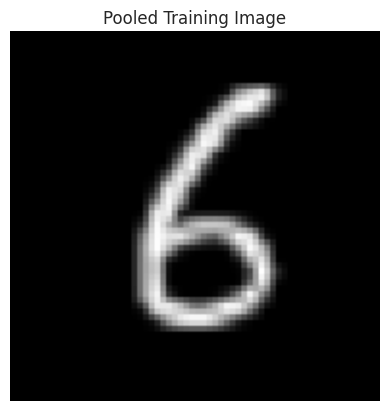

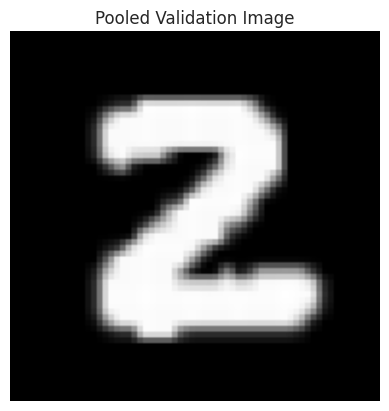

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

def max_pool_and_expand(image):
    # 对图像应用2x2的最大值池化
    pooled = maximum_filter(image, size=2, footprint=np.ones((2, 2)), mode='reflect')
    # 只取每个2x2块的第一个元素
    pooled = pooled[::2, ::2]
    # 使用kronecker积将每个值扩展到2x2的块中
    expanded_image = np.kron(pooled, np.ones((2, 2)))
    return expanded_image

# 对训练集和验证集图像应用上述函数
pooled_train_images = [max_pool_and_expand(img) for img in processed_train_images]
pooled_val_images = [max_pool_and_expand(img) for img in processed_val_images]

# 示例：显示处理后的第一个训练集图像
plt.imshow(pooled_train_images[0], cmap='gray')
plt.title('Pooled Training Image')
plt.axis('off')
plt.show()

# 示例：显示处理后的第一个验证集图像
plt.imshow(pooled_val_images[0], cmap='gray')
plt.title('Pooled Validation Image')
plt.axis('off')
plt.show()


In [21]:
Nslm = 16384  # nb of SLM pixels
Nfluo = 16384   # nb of beads
Ncam = 16384  # nb of camera pixels

pooled_train_images_flat = [img.reshape(-1) for img in pooled_train_images]  # 展开每张图像
pooled_val_images_flat = [img.reshape(-1) for img in pooled_val_images]  # 展开每张图像

SLM_input_train_pooled = np.stack(pooled_train_images_flat, axis=1)  # 沿着第二维（列）堆叠
SLM_input_val_pooled = np.stack(pooled_val_images_flat, axis=1)  # 沿着第二维（列）堆叠

# 将 NumPy 数组转换为 PyTorch 张量
SLM_input_train_pha_pooled = torch.from_numpy(SLM_input_train_pooled).float().to(device)
SLM_input_train_t_pooled = phase_to_complex(SLM_input_train_pha_pooled)

SLM_input_val_pha_pooled = torch.from_numpy(SLM_input_val_pooled).float().to(device)
SLM_input_val_t_pooled = phase_to_complex(SLM_input_val_pha_pooled)

field1_train_t_pooled = complex_matmul(T1_t, SLM_input_train_t_pooled)
int1_train_t_pooled = torch.sum(torch.abs(field1_train_t_pooled)**2,-1)

field1_val_t_pooled = complex_matmul(T1_t, SLM_input_val_t_pooled)
int1_val_t_pooled = torch.sum(torch.abs(field1_val_t_pooled)**2,-1)
# int1_val_t = int1_val_t.T
# CAM_output_t = T2_t@int1_t

In [22]:
import os

# SLM_input_train 是一个 NumPy 数组
np.save('down-sampled/train/train_image.npy', SLM_input_train_pooled)

# int1_train_t 是一个 PyTorch 张量
# 保存前确保它在 CPU 上，因为张量需要在 CPU 上才能转换为 NumPy 数组
torch.save(int1_train_t_pooled.cpu(), 'down-sampled/train/train_speckle.npy')

In [23]:
# SLM_input_train 是一个 NumPy 数组
np.save('down-sampled/val/val_image.npy', SLM_input_val_pooled)

# int1_train_t 是一个 PyTorch 张量
# 保存前确保它在 CPU 上，因为张量需要在 CPU 上才能转换为 NumPy 数组
torch.save(int1_val_t_pooled.cpu(), 'down-sampled/val/val_speckle.npy')

Saved 1000 images to down-sampled/train/input


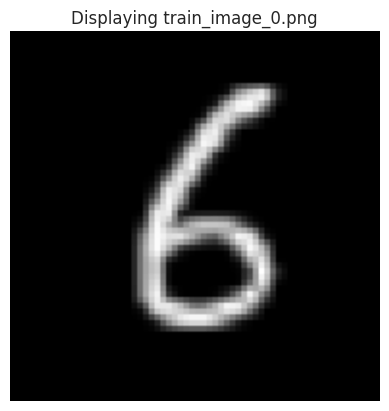

In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# 确保目标文件夹存在
output_dir = 'down-sampled/train/input'
os.makedirs(output_dir, exist_ok=True)

# 将每个处理后的验证集图像保存为.tif文件
for idx, img in enumerate(pooled_train_images):
    # 转换图像数据类型为uint8，适合保存图像文件
    img = (img - img.min()) / (img.max() - img.min())  # 归一化到0-1
    img = (img * 255).astype(np.uint8)  # 缩放到0-255

    # 创建图像对象
    image = Image.fromarray(img)
    # 构建文件路径
    file_path = os.path.join(output_dir, f'train_image_{idx}.png')
    # 保存为.tif文件
    image.save(file_path)

print(f"Saved {len(pooled_train_images)} images to {output_dir}")

file_name = 'train_image_0.png'  # 假设我们要查看的是第一个图像
file_path = os.path.join(output_dir, file_name)

# 加载图像
image = Image.open(file_path)

# 显示图像
plt.imshow(image, cmap='gray')  # 使用灰度色图显示
plt.title(f'Displaying {file_name}')
plt.axis('off')  # 不显示坐标轴
plt.show()

Saved 200 images to down-sampled/val/input


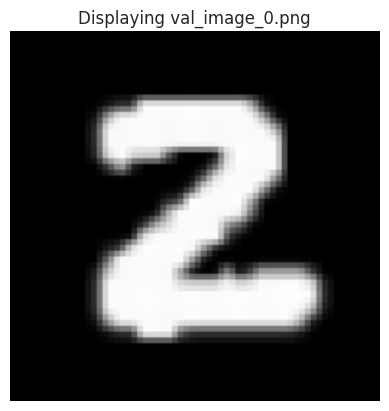

In [25]:
# 确保目标文件夹存在
output_dir = 'down-sampled/val/input'
os.makedirs(output_dir, exist_ok=True)

# 将每个处理后的验证集图像保存为.tif文件
for idx, img in enumerate(pooled_val_images):
    # 转换图像数据类型为uint8，适合保存图像文件
    img = (img - img.min()) / (img.max() - img.min())  # 归一化到0-1
    img = (img * 255).astype(np.uint8)  # 缩放到0-255

    # 创建图像对象
    image = Image.fromarray(img)
    # 构建文件路径
    file_path = os.path.join(output_dir, f'val_image_{idx}.png')
    # 保存为.tif文件
    image.save(file_path)

print(f"Saved {len(pooled_val_images)} images to {output_dir}")

file_name = 'val_image_0.png'  # 假设我们要查看的是第一个图像
file_path = os.path.join(output_dir, file_name)

# 加载图像
image = Image.open(file_path)

# 显示图像
plt.imshow(image, cmap='gray')  # 使用灰度色图显示
plt.title(f'Displaying {file_name}')
plt.axis('off')  # 不显示坐标轴
plt.show()

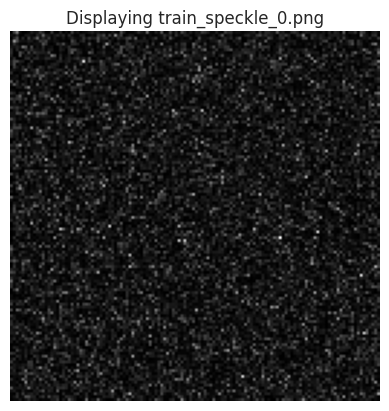

In [26]:
import torch
import matplotlib.pyplot as plt
import os

# 加载数据（使用torch.load，因为文件是用torch.save保存的）
speckle_data = torch.load('down-sampled/train/train_speckle.npy')

# 确保输出目录存在
output_dir = 'down-sampled/train/output'
os.makedirs(output_dir, exist_ok=True)

# 转换并保存图像
for i in range(speckle_data.shape[1]):  # 遍历所有列
    # 从列向量转换成128x128图像
    image = speckle_data[:, i].reshape(128, 128).numpy()  # 转换为NumPy数组
    
    # 归一化到0-1
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # 缩放到0-255并转换为整数
    image_scaled = (image_normalized * 255).astype(np.uint8)
    
    # 生成输出文件名
    output_filename = os.path.join(output_dir, f'train_speckle_{i}.png')
    
    # 保存图像
    plt.imsave(output_filename, image_scaled, cmap='gray')

file_name = 'train_speckle_0.png'  # 假设我们要查看的是第一个图像
file_path = os.path.join(output_dir, file_name)

# 加载图像
image = Image.open(file_path)

# 显示图像
plt.imshow(image, cmap='gray')  # 使用灰度色图显示
plt.title(f'Displaying {file_name}')
plt.axis('off')  # 不显示坐标轴
plt.show()


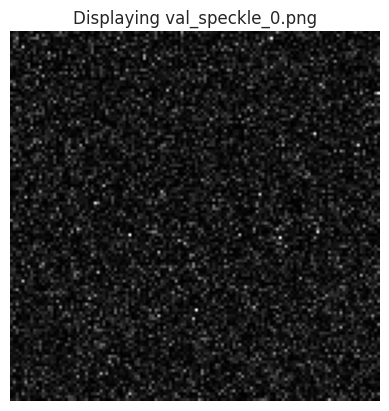

In [28]:
# 加载数据（使用torch.load，因为文件是用torch.save保存的）
speckle_data = torch.load('down-sampled/val/val_speckle.npy')

# 确保输出目录存在
output_dir = 'down-sampled/val/output'
os.makedirs(output_dir, exist_ok=True)

# 转换并保存图像
for i in range(speckle_data.shape[1]):  # 遍历所有列
    # 从列向量转换成128x128图像
    image = speckle_data[:, i].reshape(128, 128).numpy()  # 转换为NumPy数组
    
    # 归一化到0-1
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # 缩放到0-255并转换为整数
    image_scaled = (image_normalized * 255).astype(np.uint8)
    
    # 生成输出文件名
    output_filename = os.path.join(output_dir, f'val_speckle_{i}.png')
    
    # 保存图像
    plt.imsave(output_filename, image_scaled, cmap='gray')

file_name = 'val_speckle_0.png'  # 假设我们要查看的是第一个图像
file_path = os.path.join(output_dir, file_name)

# 加载图像
image = Image.open(file_path)

# 显示图像
plt.imshow(image, cmap='gray')  # 使用灰度色图显示
plt.title(f'Displaying {file_name}')
plt.axis('off')  # 不显示坐标轴
plt.show()